# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [2]:
# Set seed for Python's built-in random number generator

# Set seed for numpy. Put your SID instead of number '42'
np.random.seed(2167288) 
# Set seed for Python's built-in random number generator.  Put your SID instead of number '42'
random.seed(2167288)

# Set seed for TensorFlow tf.random.set_seed(42)
# Put your SID instead of number '42'
tf.random.set_seed(2167288)

K.clear_session() # Set seed for Keras

In [102]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [103]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [104]:
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [105]:
# Define client functions
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, 
              #verbose=0,
             verbose=1)
    return model

## 2 Clients

In [7]:
# Split data into two clients
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, 
                                                                  #random_state=42,
                                                  # Put your SID instead of number '42'                
                                                                  random_state= 2167288
                                                                 )

In [8]:
print(x_train_c1.shape)
print(x_train_c2.shape)
print(y_train_c1.shape)
print(y_train_c2.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000,)
(30000,)


In [9]:
# Create and train client models

client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)


Epoch 1/5


938/938 [==============================] - 2s 2ms/step - loss: 0.3468 - accuracy: 0.9024
Epoch 2/5
938/938 [==============================] - 1s 2ms/step - loss: 0.1636 - accuracy: 0.9519
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1132 - accuracy: 0.9652
Epoch 4/5
938/938 [==============================] - 1s 2ms/step - loss: 0.0824 - accuracy: 0.9745
Epoch 5/5
938/938 [==============================] - 1s 2ms/step - loss: 0.0626 - accuracy: 0.9818
Epoch 1/5
938/938 [==============================] - 2s 2ms/step - loss: 0.3406 - accuracy: 0.9042
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1607 - accuracy: 0.9547
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1094 - accuracy: 0.9692
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0818 - accuracy: 0.9762
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9828


In [10]:
# Federated averaging

def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [11]:
# Aggregate models

aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [12]:
# Create global model and set weights

global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [13]:
# Evaluate global model

test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 0.4086 - accuracy: 0.8851 - 508ms/epoch - 2ms/step
Test accuracy: 0.8851000070571899


In [14]:
test_accuracy = []

In [15]:
test_accuracy.append(0.8851000070571899)

In [16]:
test_accuracy

[0.8851000070571899]

#### Write your code to calculate precision, recall, and F-score


In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [18]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 1ms/step
(10000, 10)


In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.57      0.72       980
           1       0.99      0.97      0.98      1135
           2       0.88      0.97      0.92      1032
           3       0.97      0.83      0.89      1010
           4       0.97      0.86      0.91       982
           5       0.62      0.98      0.76       892
           6       0.93      0.95      0.94       958
           7       0.95      0.93      0.94      1028
           8       0.92      0.85      0.88       974
           9       0.82      0.94      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.90      0.88      0.88     10000
weighted avg       0.91      0.89      0.89     10000



In [20]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

Accuracy test set:  0.8851
Precision test set:  0.907323157047967
Recall test set:  0.8851
F-score test set:  0.8851514824563385


In [21]:
test_precision = []
test_recall    = []
test_f1_score  = []

In [22]:
test_precision.append(0.907323157047967)
test_recall.append(0.8851)
test_f1_score.append(0.8851514824563385)

#### Display confusion matrix between actual and predicted values on the test data.


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

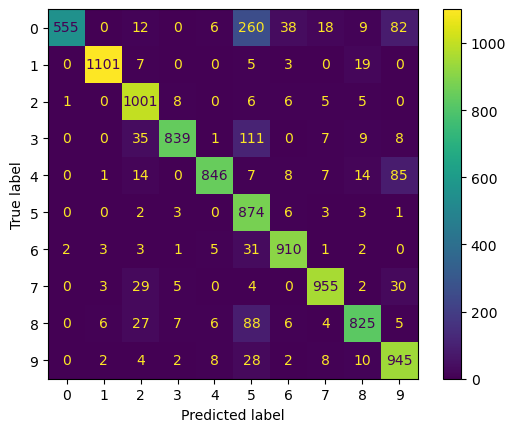

In [24]:
# display confusion matrix between test output and predicted output

cm = confusion_matrix(y_test, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();
#plt.show()

## Lab Logbook requirement: Document the

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.

## Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

## 4 Clients

In [25]:
# Split data into 4 clients

In [26]:
Client_1 = (x_train[0:15000], y_train[0:15000])
Client_2 = (x_train[15000:30000], y_train[15000:30000])
Client_3 = (x_train[30000:45000], y_train[30000:45000])
Client_4 = (x_train[45000:], y_train[45000:])

In [27]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [28]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])

Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.4454 - accuracy: 0.8747
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2176 - accuracy: 0.9391
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1564 - accuracy: 0.9542
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1147 - accuracy: 0.9679
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0884 - accuracy: 0.9749
Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 2.3137 - accuracy: 0.1001
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2961 - accuracy: 0.1179
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2867 - accuracy: 0.1295
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2719 - accuracy: 0.1421
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2524 - accuracy: 0.1573
Epoch 1/5


In [29]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2, weights3, weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights


In [30]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [31]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 0s - loss: 2.2344 - accuracy: 0.2879 - 475ms/epoch - 2ms/step
Test accuracy: 0.28790000081062317


In [32]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 1ms/step
(10000, 10)


In [33]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

Accuracy test set:  0.2879
Precision test set:  0.37310911314701634
Recall test set:  0.2879
F-score test set:  0.2500357846568731
              precision    recall  f1-score   support

           0       0.75      0.01      0.02       980
           1       0.37      0.95      0.54      1135
           2       0.21      0.14      0.17      1032
           3       0.32      0.09      0.14      1010
           4       0.23      0.13      0.17       982
           5       0.50      0.41      0.45       892
           6       0.69      0.30      0.42       958
           7       0.15      0.47      0.22      1028
           8       0.32      0.10      0.15       974
           9       0.22      0.18      0.20      1009

    accuracy                           0.29     10000
   macro avg       0.38      0.28      0.25     10000
weighted avg       0.37      0.29      0.25     10000



In [34]:
test_accuracy.append(0.28790000081062317)
test_precision.append(0.37310911314701634)
test_recall.append(0.2879)
test_f1_score.append(0.2500357846568731)

In [35]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317]
[0.907323157047967, 0.37310911314701634]
[0.8851, 0.2879]
[0.8851514824563385, 0.2500357846568731]


## 6 Clients

In [36]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [37]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5202 - accuracy: 0.8563
Epoch 2/5
313/313 [==============================] - 0s 2ms/step - loss: 0.2467 - accuracy: 0.9317
Epoch 3/5
313/313 [==============================] - 0s 2ms/step - loss: 0.1833 - accuracy: 0.9489
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1387 - accuracy: 0.9600
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1107 - accuracy: 0.9695
Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 2.3186 - accuracy: 0.1024
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2948 - accuracy: 0.1240
Epoch 3/5
313/313 [==============================] - 0s 2ms/step - loss: 2.2831 - accuracy: 0.1319
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2599 - accuracy: 0.1515
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2372 - accuracy: 0.1629
Epoch 1/5


In [38]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [39]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 1.9594 - accuracy: 0.7272 - 476ms/epoch - 2ms/step
Test accuracy: 0.7271999716758728
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.7272
Precision test set:  0.7834205071021751
Recall test set:  0.7272
F-score test set:  0.7308748558259915
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       980
           1       0.97      0.68      0.80      1135
           2       0.86      0.81      0.83      1032
           3       0.95      0.43      0.59      1010
           4       0.80      0.69      0.74       982
           5       0.73      0.78      0.76       892
           6       0.81      0.88      0.84       958
           7       0.46      0.88      0.61      1028
           8       0.59      0.67      0.63       974
           9       0.69      0.83      0.75      1009

    accuracy                           0.73     10000
   macro avg       0.78      0.73      0.73    

In [40]:
test_accuracy.append(0.7271999716758728)
test_precision.append(0.7834205071021751)
test_recall.append(0.7272)
test_f1_score.append(0.7308748558259915)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751]
[0.8851, 0.2879, 0.7272]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915]


## 8 Clients

In [41]:
Client_1 = (x_train[0:7500], y_train[0:7500])
Client_2 = (x_train[7500:15000], y_train[7500:15000])
Client_3 = (x_train[15000:22500], y_train[15000:22500])
Client_4 = (x_train[22500:30000], y_train[22500:30000])
Client_5 = (x_train[30000:37500], y_train[30000:37500])
Client_6 = (x_train[37500:45000], y_train[37500:45000])
Client_7 = (x_train[45000:52500], y_train[45000:52500])
Client_8 = (x_train[52500:], y_train[52500:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
Epoch 1/5
235/235 [==============================] - 1s 2ms/step - loss: 0.5663 - accuracy: 0.8443
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 0.2560 - accuracy: 0.9284
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1897 - accuracy: 0.9476
Epoch 4/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.9615
Epoch 5/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1145 - accuracy: 0.9704
Epoch 1/5
235/235 [==============================] - 1s 2ms/step - loss: 2.3256 - accuracy: 0.1003
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2903 - accuracy: 0.1300
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2707 - accuracy: 0.1460


In [42]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, 
                              weights5, weights6, weights7, weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2, weights3, weights4, 
                                              weights5, weights6, weights7, weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 +w8) / 8)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [43]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 1.8108 - accuracy: 0.6028 - 481ms/epoch - 2ms/step
Test accuracy: 0.6028000116348267
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.6028
Precision test set:  0.7986126719530607
Recall test set:  0.6028
F-score test set:  0.5536289939655649
              precision    recall  f1-score   support

           0       1.00      0.07      0.12       980
           1       0.99      0.87      0.93      1135
           2       0.66      0.83      0.73      1032
           3       0.80      0.79      0.80      1010
           4       0.83      0.85      0.84       982
           5       0.26      0.92      0.41       892
           6       0.97      0.63      0.76       958
           7       0.54      0.94      0.68      1028
           8       0.99      0.09      0.17       974
           9       0.89      0.01      0.02      1009

    accuracy                           0.60     10000
   macro avg       0.79      0.60      0.55    

In [44]:
test_accuracy.append(0.6028000116348267)
test_precision.append(0.7986126719530607)
test_recall.append(0.6028)
test_f1_score.append(0.5536289939655649)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607]
[0.8851, 0.2879, 0.7272, 0.6028]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649]


## 10 Clients

In [45]:
Client_1 = (x_train[0:6000], y_train[0:6000])
Client_2 = (x_train[6000:12000], y_train[6000:12000])
Client_3 = (x_train[12000:18000], y_train[12000:18000])
Client_4 = (x_train[18000:24000], y_train[18000:24000])
Client_5 = (x_train[24000:30000], y_train[24000:30000])
Client_6 = (x_train[30000:36000], y_train[30000:36000])
Client_7 = (x_train[36000:42000], y_train[36000:42000])
Client_8 = (x_train[42000:48000], y_train[42000:48000])
Client_9 = (x_train[48000:54000], y_train[48000:54000])
Client_10 = (x_train[54000:], y_train[54000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)
print(Client_9[0].shape)
print(Client_10[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)
print(Client_9[1].shape)
print(Client_10[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])
client9_model = train_client_model(client9_model, Client_9[0], Client_9[1])
client10_model = train_client_model(client10_model, Client_10[0], Client_10[1])

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 0.6118 - accuracy: 0.8352
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2773 - accuracy: 0.9223
Epoch 3/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.9450
Epoch 4/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1588 - accuracy: 0.9558
Epoch 5/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1237 - accuracy: 0.9663
Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 2.3302 - accuracy: 0.0973
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 2.2839 - accuracy: 0.1335
Epoch 3/5
188/188 [============================

In [46]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5,
                              weights6, weights7, weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2, weights3, weights4, 
                                                      weights5, weights6, weights7, weights8, 
                                                      weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights(),
                                               client9_model.get_weights(),
                                               client10_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [47]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.8502 - accuracy: 0.6429 - 508ms/epoch - 2ms/step
Test accuracy: 0.6428999900817871
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.6429
Precision test set:  0.8044962589008876
Recall test set:  0.6429
F-score test set:  0.6203729491096158
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       980
           1       1.00      0.82      0.90      1135
           2       0.68      0.93      0.79      1032
           3       0.84      0.12      0.22      1010
           4       0.95      0.76      0.85       982
           5       0.30      0.95      0.45       892
           6       0.91      0.76      0.83       958
           7       0.93      0.57      0.70      1028
           8       0.89      0.02      0.03       974
           9       0.49      0.90      0.63      1009

    accuracy                           0.64     10000
   macro avg       0.80      0.64      0.61    

In [48]:
test_accuracy.append(0.6428999900817871)
test_precision.append(0.8044962589008876)
test_recall.append(0.6429)
test_f1_score.append(0.6203729491096158)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876]
[0.8851, 0.2879, 0.7272, 0.6028, 0.6429]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]


### Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

In [49]:
import pandas as pd

In [50]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871], [0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876], [0.8851, 0.2879, 0.7272, 0.6028, 0.6429], [0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]]


,Accuracy,Precision,Recall,F1_Score
2,0.8851,0.907323,0.8851,0.885151
4,0.2879,0.373109,0.2879,0.250036
6,0.7272,0.783421,0.7272,0.730875
8,0.6028,0.798613,0.6028,0.553629
10,0.6429,0.804496,0.6429,0.620373


<Axes: >

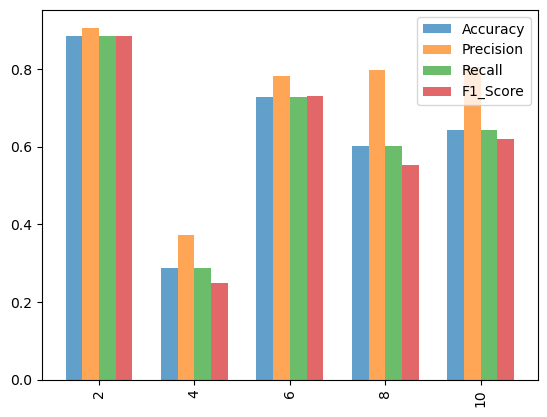

In [51]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

### 2.For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.

#### Take 6 Clients, one of them is assumed dishonest



In [65]:
# Split data into 6 clients

In [106]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

In [107]:
Client_2[1].size

10000

In [108]:
Client_2[1]

array([3, 8, 7, ..., 1, 4, 2], dtype=uint8)

In [109]:
### Client_2 is assumed dishonest and changing the training data. Some labels are set as 4 
### Change the first 2000 labels

Client_2[1][:2000] = 4

In [110]:
Client_2[1]

array([4, 4, 4, ..., 1, 4, 2], dtype=uint8)

In [111]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [112]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5229 - accuracy: 0.8590
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.2414 - accuracy: 0.9304
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1776 - accuracy: 0.9508
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1330 - accuracy: 0.9635
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.1045 - accuracy: 0.9712
Epoch 1/5
313/313 [==============================] - 2s 2ms/step - loss: 2.3198 - accuracy: 0.1056
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2949 - accuracy: 0.1164
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2815 - accuracy: 0.1360
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2617 - accuracy: 0.1532
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2336 - accuracy: 0.1746
Epoch 1/5


In [113]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [114]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.9523 - accuracy: 0.7198 - 512ms/epoch - 2ms/step
Test accuracy: 0.7197999954223633
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.7198
Precision test set:  0.7649681801937827
Recall test set:  0.7198
F-score test set:  0.7079021148713025
              precision    recall  f1-score   support

           0       0.99      0.55      0.70       980
           1       0.78      0.96      0.86      1135
           2       0.92      0.72      0.81      1032
           3       0.67      0.62      0.64      1010
           4       0.60      0.86      0.71       982
           5       0.48      0.88      0.62       892
           6       0.74      0.92      0.82       958
           7       0.80      0.64      0.71      1028
           8       0.80      0.82      0.81       974
           9       0.83      0.24      0.37      1009

    accuracy                           0.72     10000
   macro avg       0.76      0.72      0.71    

In [115]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [116]:
test_accuracy_dishonest.append(test_accuracy[2])
test_precision_dishonest.append(test_precision[2])
test_recall_dishonest.append(test_recall[2])
test_f1_score_dishonest.append(test_f1_score[2])

test_accuracy_dishonest.append(0.7197999954223633)
test_precision_dishonest.append(0.7649681801937827)
test_recall_dishonest.append(0.7198)
test_f1_score_dishonest.append(0.7079021148713025)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.7271999716758728, 0.7197999954223633]
[0.7834205071021751, 0.7649681801937827]
[0.7272, 0.7198]
[0.7308748558259915, 0.7079021148713025]


In [117]:
### Plot the model's performance for the 6 clients, one of them (number=2) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['All are honest', '#2 is dishonest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.7271999716758728, 0.7197999954223633], [0.7834205071021751, 0.7649681801937827], [0.7272, 0.7198], [0.7308748558259915, 0.7079021148713025]]


,Accuracy,Precision,Recall,F1_Score
All are honest,0.7272,0.783421,0.7272,0.730875
#2 is dishonest,0.7198,0.764968,0.7198,0.707902


<Axes: >

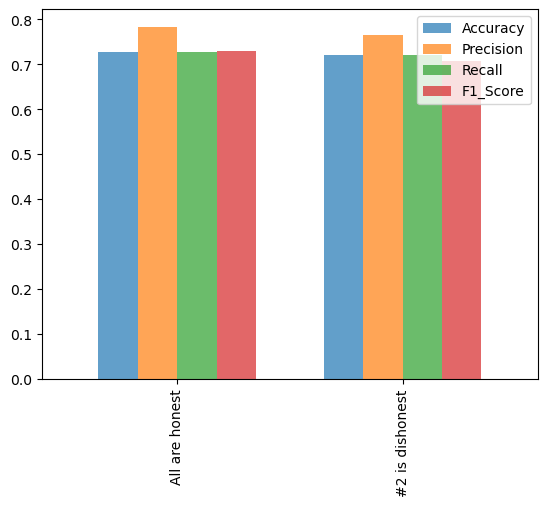

In [118]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)